### Name: Mukund Tamizharasan
### USC ID: 7355725345

# Supervised, Semi-Supervised, and Unsupervised Learning

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
from scipy.special import softmax
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import softmax


In [156]:
col_names=["ID number","Diagnosis"]
features=["radius","texture","perimeter","area","smoothness","compactness","concavity","concave points","symmetry","fractal dimension"]
measures=["mean","std_error","worst"]

for feature in features:
    for measure in measures:
        col_names.append(measure+"_"+feature)
len(col_names)

32

In [157]:
df=pd.read_csv("../data/wdbc.data",names=col_names)
df.replace({'B' : 0, 'M' : 1}, inplace=True)
df

,ID number,Diagnosis,mean_radius,std_error_radius,worst_radius,mean_texture,std_error_texture,worst_texture,mean_perimeter,std_error_perimeter,...,worst_concavity,mean_concave points,std_error_concave points,worst_concave points,mean_symmetry,std_error_symmetry,worst_symmetry,mean_fractal dimension,std_error_fractal dimension,worst_fractal dimension
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [158]:
df_m = df[df["Diagnosis"]==1]
df_b = df[df["Diagnosis"]==0]

#### 1. (b) i. Supervised Learning: Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs.

In [31]:
def plot_curve(y,ypred,ypred_prob,split):
    fpr, tpr, thresholds = roc_curve(y,ypred_prob)
    roc_auc = auc(fpr, tpr)
    confusion_mat = confusion_matrix(y,ypred)
    
    print("Confusion Matrix "+split+" Set")
    print(confusion_mat)

    plt.figure()
    plt.title('ROC Curve '+split+' Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

In [32]:
def linear_svc(df_m,df_b):
    
    train_summary_df = pd.DataFrame(columns=["accuracy","precision","recall","f1_score","auc"])
    test_summary_df = pd.DataFrame(columns=["accuracy","precision","recall","f1_score","auc"])
    idx_train = 0
    idx_test = 0
    
    for m in range(30):
        print("Monte Carlo Simulation ",m+1)
        
        df_m_train, df_m_test = train_test_split(df_m, test_size=0.2, random_state=(m+1)*10)
        df_b_train, df_b_test = train_test_split(df_b, test_size=0.2, random_state=(m+1)*10)
        
        df_train = pd.concat([df_m_train, df_b_train])
        df_test = pd.concat([df_m_test, df_b_test])
        
        xtrain, ytrain = df_train.iloc[:,2:], df_train.iloc[:,1]
        xtest, ytest = df_test.iloc[:,2:], df_test.iloc[:,1]
        
        scaler = MinMaxScaler()
        scaler.fit(xtrain)
        xtrain_norm = scaler.transform(xtrain)
        xtest_norm = scaler.transform(xtest)
        
        splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=(m+1)*10)
        C_list = [10**i for i in range(-3,10)]

        params = {"C":C_list}

        estimator = LinearSVC(penalty="l1", dual=False, verbose=1)

        clf = GridSearchCV(estimator=estimator, param_grid=params, scoring="f1_weighted", n_jobs=-1, cv=splitter, verbose=2)
        clf.fit(xtrain_norm,ytrain)

        print("Best parameter is ",clf.best_params_)

        ytrain_pred = clf.predict(xtrain_norm)
        train_acc = accuracy_score(ytrain,ytrain_pred)
        train_prec = precision_score(ytrain,ytrain_pred)
        train_rec = recall_score(ytrain,ytrain_pred)
        train_f1 = f1_score(ytrain,ytrain_pred)
        ypred_prob = clf.decision_function(xtrain_norm)
        fpr, tpr, thresholds = roc_curve(ytrain,ypred_prob)
        roc_auc_train = auc(fpr, tpr)
        train_summary_df.loc[idx_train] = [train_acc,train_prec,train_rec,train_f1,roc_auc_train]
        idx_train+=1
        
        ytest_pred = clf.predict(xtest_norm)
        test_acc = accuracy_score(ytest,ytest_pred)
        test_prec = precision_score(ytest,ytest_pred)
        test_rec = recall_score(ytest,ytest_pred)
        test_f1 = f1_score(ytest,ytest_pred)
        ypred_prob = clf.decision_function(xtest_norm)
        fpr, tpr, thresholds = roc_curve(ytest,ypred_prob)
        roc_auc_test = auc(fpr, tpr)
        test_summary_df.loc[idx_test] = [test_acc,test_prec,test_rec,test_f1,roc_auc_test]
        idx_test+=1
        
        if m==29:
            print("Confusion matrix and ROC curve for simulation 30")
            ypred_prob = clf.decision_function(xtrain_norm)
            plot_curve(ytrain,ytrain_pred,ypred_prob,"Training")
            
            ypred_prob = clf.decision_function(xtest_norm)
            plot_curve(ytest,ytest_pred,ypred_prob,"Test")
                                                                                          
    return train_summary_df,test_summary_df 

Monte Carlo Simulation  1
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[LibLinear]Best parameter is  {'C': 1}
Monte Carlo Simulation  2
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[LibLinear]Best parameter is  {'C': 1}
Monte Carlo Simulation  3
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[LibLinear]Best parameter is  {'C': 1}
Monte Carlo Simulation  4
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[LibLinear]Best parameter is  {'C': 10}
Monte Carlo Simulation  5
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[LibLinear]Best parameter is  {'C': 100}
Monte Carlo Simulation  6
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[LibLinear]Best parameter is  {'C': 10}
Monte Carlo Simulation  7
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[LibLinear]Best parameter is  {'C': 1}
Monte Carlo Simulation  8
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[LibLinear]Best parameter i

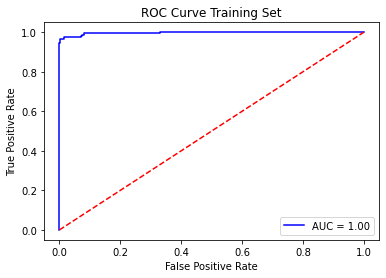

Confusion Matrix Test Set
[[72  0]
 [ 0 43]]


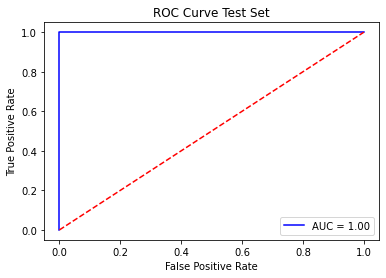

In [33]:
train_summary_df,test_summary_df = linear_svc(df_m,df_b)

In [34]:
print("Train Summary")
train_summary_df.mean()

Train Summary


accuracy     0.987885
precision    0.992578
recall       0.974753
f1_score     0.983555
auc          0.998237
dtype: float64

In [35]:
print("Test Summary")
test_summary_df.mean()

Test Summary


accuracy     0.965797
precision    0.969175
recall       0.939535
f1_score     0.953419
auc          0.991354
dtype: float64

In [36]:
average_scores ={
    "l1-svm":{
        "train":train_summary_df.mean(),
        "test":test_summary_df.mean()
    }
}

#### 1. (b) ii. Semi-Supervised Learning/ Self-training: select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.

In [37]:
def semi_supervised(df_m,df_b):
    
    train_summary_df = pd.DataFrame(columns=["accuracy","precision","recall","f1_score","auc"])
    test_summary_df = pd.DataFrame(columns=["accuracy","precision","recall","f1_score","auc"])
    idx_train = 0
    idx_test = 0
    
    for m in range(30):
        print("Monte Carlo Simulation ",m+1)
        
        df_m_train, df_m_test = train_test_split(df_m, test_size=0.2, random_state=(m+1)*10)
        df_b_train, df_b_test = train_test_split(df_b, test_size=0.2, random_state=(m+1)*10)
        
        df_train = pd.concat([df_m_train, df_b_train])
        df_test = pd.concat([df_m_test, df_b_test])
        
        xtrain, ytrain = df_train.iloc[:,2:].values, df_train.iloc[:,1].values
        xtest, ytest = df_test.iloc[:,2:].values, df_test.iloc[:,1].values
        
        scaler = MinMaxScaler()
        scaler.fit(xtrain)
        df_train = pd.DataFrame(scaler.transform(xtrain),columns=col_names[2:])
        df_train["Diagnosis"] = ytrain
        df_test = pd.DataFrame(scaler.transform(xtest),columns=col_names[2:])
        df_test["Diagnosis"] = ytest
        
        df_m_train = df_train[df_train["Diagnosis"]==1]
        df_b_train = df_train[df_train["Diagnosis"]==0]
        
        df_m_lbl, df_m_unlbl = train_test_split(df_m_train, test_size=0.5, random_state=(m+1)*10)
        df_b_lbl, df_b_unlbl = train_test_split(df_b_train, test_size=0.5, random_state=(m+1)*10)
        
        df_train_lbl = pd.concat([df_m_lbl, df_b_lbl], ignore_index=True)
        df_train_unlbl = pd.concat([df_m_unlbl,df_b_unlbl], ignore_index=True)
        df_train_unlbl.drop(columns=['Diagnosis'], inplace=True)
        
         
        splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=(m+1)*10)
        C_list = [10**i for i in range(-3,10)]
        params = {"C":C_list}
        estimator = LinearSVC(penalty="l1", dual=False, verbose=0)
        
        clf = GridSearchCV(estimator=estimator, param_grid=params, scoring="f1_weighted", n_jobs=-1, cv=splitter, verbose=1)
        clf.fit(df_train_lbl.iloc[:,:-1],df_train_lbl.iloc[:,-1])
        
        while(len(df_train_unlbl)>0):
            
            probs = clf.decision_function(df_train_unlbl)
            df_train_unlbl["probs"]=probs
            df_train_unlbl=df_train_unlbl.abs()
            df_train_unlbl.sort_values(by=['probs'],inplace=True)
            
            temp1= list(df_train_unlbl[df_train_unlbl.probs == df_train_unlbl.iloc[-1]["probs"]].to_numpy()[0][:-1])
            unlbl_pred = clf.predict([temp1])
            r = temp1 + list(unlbl_pred)
            df_train_lbl.loc[len(df_train_lbl)] = r
            
            df_train_unlbl = df_train_unlbl[:-1]
            df_train_unlbl.reset_index()
            df_train_unlbl.drop(columns=['probs'], inplace=True)
            
            clf.best_estimator_.fit(df_train_lbl.iloc[:,:-1],df_train_lbl.iloc[:,-1])
    
        
        print("Best parameter is ",clf.best_params_)
        
        xtrain, ytrain = df_train_lbl.iloc[:,:-1], df_train_lbl.iloc[:,-1]
        xtest, ytest = df_test.iloc[:,:-1], df_test.iloc[:,-1]
        
        ytrain_pred = clf.predict(xtrain)
        train_acc = accuracy_score(ytrain,ytrain_pred)
        train_prec = precision_score(ytrain,ytrain_pred)
        train_rec = recall_score(ytrain,ytrain_pred)
        train_f1 = f1_score(ytrain,ytrain_pred)
        ypred_prob = clf.decision_function(xtrain)
        fpr, tpr, thresholds = roc_curve(ytrain,ypred_prob)
        roc_auc_train = auc(fpr, tpr)
        train_summary_df.loc[idx_train] = [train_acc,train_prec,train_rec,train_f1,roc_auc_train]
        idx_train+=1
        
        ytest_pred = clf.predict(xtest)
        test_acc = accuracy_score(ytest,ytest_pred)
        test_prec = precision_score(ytest,ytest_pred)
        test_rec = recall_score(ytest,ytest_pred)
        test_f1 = f1_score(ytest,ytest_pred)
        ypred_prob = clf.decision_function(xtest)
        fpr, tpr, thresholds = roc_curve(ytest,ypred_prob)
        roc_auc_test = auc(fpr, tpr)
        test_summary_df.loc[idx_test] = [test_acc,test_prec,test_rec,test_f1,roc_auc_test]
        idx_test+=1
        
        if m==29:
            print("Confusion matrix and ROC curve for simulation 30")
            ypred_prob = clf.decision_function(xtrain)
            plot_curve(ytrain,ytrain_pred,ypred_prob,"Training")
            
            ypred_prob = clf.decision_function(xtest)
            plot_curve(ytest,ytest_pred,ypred_prob,"Test")
    
    return train_summary_df,test_summary_df     

Monte Carlo Simulation  1
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameter is  {'C': 100}
Monte Carlo Simulation  2
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameter is  {'C': 10}
Monte Carlo Simulation  3
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameter is  {'C': 1}
Monte Carlo Simulation  4
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameter is  {'C': 1}
Monte Carlo Simulation  5
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameter is  {'C': 1}
Monte Carlo Simulation  6
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameter is  {'C': 1}
Monte Carlo Simulation  7
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameter is  {'C': 10}
Monte Carlo Simulation  8
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameter is  {'C': 1}
Monte Carlo Simulation  9
Fitting 5 folds for each of 13 candidates, totalli

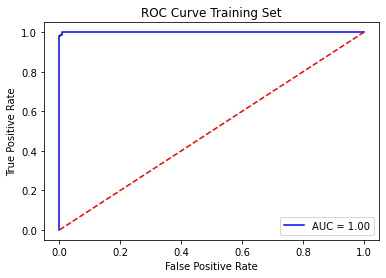

Confusion Matrix Test Set
[[72  0]
 [ 0 43]]


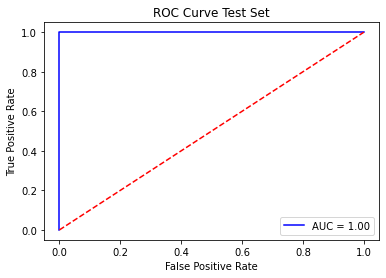

In [38]:
train_summary_df,test_summary_df = semi_supervised(df_m,df_b)

In [39]:
print("Train Summary")
train_summary_df.mean()

Train Summary


accuracy     0.992952
precision    0.996714
recall       0.983761
f1_score     0.990167
auc          0.998966
dtype: float64

In [40]:
print("Test Summary")
test_summary_df.mean()

Test Summary


accuracy     0.966377
precision    0.979352
recall       0.930233
f1_score     0.953616
auc          0.989341
dtype: float64

In [41]:
average_scores["semi-supervised"] ={
        "train":train_summary_df.mean(),
        "test":test_summary_df.mean()
}

#### 1. (b) iii. Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.

In [194]:
def majority(x,y,label,dist):

    majority_label = label.copy()
    cluster_labels = np.ndarray((2,), dtype='int')
    for c in [0, 1]:
        cluster_idx, = np.where(label == c)
        distsort = sorted(cluster_idx.tolist(), key=lambda i : dist[i])[:30]
        majority = y.iloc[distsort].value_counts().index[0]
        majority_label[cluster_idx] = majority
        cluster_labels[majority] = c
    return cluster_labels, majority_label

def distance(x,cluster_centers,label):
    
    prob = np.ndarray((x.shape[0], 2))
    dist = np.ndarray((x.shape[0],))
    for i, ix in enumerate(x):
        center = cluster_centers[label[i]]
        dist[i] = np.linalg.norm(ix - center)
        prob[i, 1] = np.linalg.norm(ix - cluster_centers[1])
        prob[i, 0] = np.linalg.norm(ix - cluster_centers[0])
        
    prob = softmax(prob, axis=1).astype(np.float64)
    return dist, prob

In [211]:
def kmeans(df_m,df_b):
    
    train_summary_df = pd.DataFrame(columns=["accuracy","precision","recall","f1_score","auc"])
    test_summary_df = pd.DataFrame(columns=["accuracy","precision","recall","f1_score","auc"])
    idx_train = 0
    idx_test = 0
    
    for m in range(30):
        print("Monte Carlo Simulation ",m+1)
        
        df_m_train, df_m_test = train_test_split(df_m, test_size=0.2, random_state=(m+1)*10)
        df_b_train, df_b_test = train_test_split(df_b, test_size=0.2, random_state=(m+1)*10)
        
        df_train = pd.concat([df_m_train, df_b_train],ignore_index=True)
        df_test = pd.concat([df_m_test, df_b_test],ignore_index=True)
        
        xtrain, ytrain = df_train.iloc[:,2:], df_train.iloc[:,1]
        xtest, ytest = df_test.iloc[:,2:], df_test.iloc[:,1]
        
        scaler = MinMaxScaler()
        scaler.fit(xtrain)
        xtrain = pd.DataFrame(scaler.transform(xtrain),columns=df_m.columns[2:])
        xtest = pd.DataFrame(scaler.transform(xtest),columns=df_m.columns[2:])
        
        clusterer = KMeans(n_clusters=2, init='random', random_state=(m+1)*10)
        clusterer.fit(xtrain)
        
        dist, ypred_prob_train = distance(xtrain.iloc[:,:].values, clusterer.cluster_centers_,  clusterer.labels_)
        major_labels_train, ytrain_pred = majority(xtrain.iloc[:,:].values,ytrain, clusterer.labels_, dist)
        
        train_acc = accuracy_score(ytrain,ytrain_pred)
        train_prec = precision_score(ytrain,ytrain_pred)
        train_rec = recall_score(ytrain,ytrain_pred)
        train_f1 = f1_score(ytrain,ytrain_pred)
        fpr, tpr, thresholds = roc_curve(ytrain,ypred_prob_train[:,major_labels_train[0]])
        roc_auc_train = auc(fpr, tpr)
        train_summary_df.loc[idx_train] = [train_acc,train_prec,train_rec,train_f1,roc_auc_train]
        idx_train+=1
        
        test_labels = clusterer.predict(xtest)
        
        dist, ypred_prob_test = distance(xtest.iloc[:,:].values, clusterer.cluster_centers_, test_labels)
        major_labels_test, ytest_pred = majority(xtest.iloc[:,:].values,ytest,test_labels, dist)
        
        test_acc = accuracy_score(ytest,ytest_pred)
        test_prec = precision_score(ytest,ytest_pred)
        test_rec = recall_score(ytest,ytest_pred)
        test_f1 = f1_score(ytest,ytest_pred)
        fpr, tpr, thresholds = roc_curve(ytest,ypred_prob_test[:,major_labels_test[0]])
        roc_auc_test = auc(fpr, tpr)
        test_summary_df.loc[idx_test] = [test_acc,test_prec,test_rec,test_f1,roc_auc_test]
        idx_test+=1
        
        if m==29:
            print("Confusion matrix and ROC curve for simulation 30")
            plot_curve(ytrain,ytrain_pred,ypred_prob_train[:,major_labels_train[0]],"Training")
            
            plot_curve(ytest,ytest_pred,ypred_prob_test[:,major_labels_test[0]],"Test")
    
    return train_summary_df,test_summary_df  

Monte Carlo Simulation  1
Monte Carlo Simulation  2
Monte Carlo Simulation  3
Monte Carlo Simulation  4
Monte Carlo Simulation  5
Monte Carlo Simulation  6
Monte Carlo Simulation  7
Monte Carlo Simulation  8
Monte Carlo Simulation  9
Monte Carlo Simulation  10
Monte Carlo Simulation  11
Monte Carlo Simulation  12
Monte Carlo Simulation  13
Monte Carlo Simulation  14
Monte Carlo Simulation  15
Monte Carlo Simulation  16
Monte Carlo Simulation  17
Monte Carlo Simulation  18
Monte Carlo Simulation  19
Monte Carlo Simulation  20
Monte Carlo Simulation  21
Monte Carlo Simulation  22
Monte Carlo Simulation  23
Monte Carlo Simulation  24
Monte Carlo Simulation  25
Monte Carlo Simulation  26
Monte Carlo Simulation  27
Monte Carlo Simulation  28
Monte Carlo Simulation  29
Monte Carlo Simulation  30
Confusion matrix and ROC curve for simulation 30
Confusion Matrix Training Set
[[277   8]
 [ 31 138]]


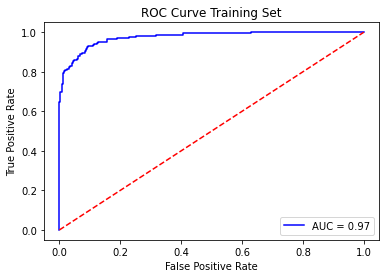

Confusion Matrix Test Set
[[72  0]
 [ 1 42]]


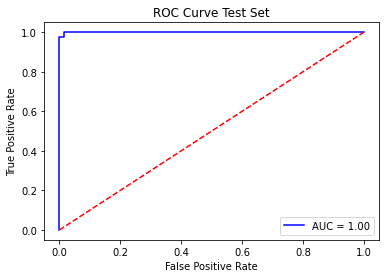

In [212]:
train_summary_df,test_summary_df = kmeans(df_m,df_b)

In [215]:
print("Train Summary")
train_summary_df.mean()

Train Summary


accuracy     0.924890
precision    0.950513
recall       0.842406
f1_score     0.893021
auc          0.979948
dtype: float64

In [216]:
print("Test Summary")
test_summary_df.mean()

Test Summary


accuracy     0.929275
precision    0.952895
recall       0.853488
f1_score     0.899639
auc          0.980373
dtype: float64

In [217]:
average_scores["unsupervised"] ={
        "train":train_summary_df.mean(),
        "test":test_summary_df.mean()
}

#### 1. (b) iv. Spectral Clustering

In [227]:
def spectral(df_m,df_b):
    
    train_summary_df = pd.DataFrame(columns=["accuracy","precision","recall","f1_score","auc"])
    test_summary_df = pd.DataFrame(columns=["accuracy","precision","recall","f1_score","auc"])
    idx_train = 0
    idx_test = 0
    
    for m in range(30):
        print("Monte Carlo Simulation ",m+1)
        
        df_m_train, df_m_test = train_test_split(df_m, test_size=0.2, random_state=(m+1))
        df_b_train, df_b_test = train_test_split(df_b, test_size=0.2, random_state=(m+1))
        
        df_train = pd.concat([df_m_train, df_b_train],ignore_index=True)
        df_test = pd.concat([df_m_test, df_b_test],ignore_index=True)
        
        xtrain, ytrain = df_train.iloc[:,2:], df_train.iloc[:,1]
        xtest, ytest = df_test.iloc[:,2:], df_test.iloc[:,1]
        
        scaler = MinMaxScaler()
        scaler.fit(xtrain)
        xtrain = pd.DataFrame(scaler.transform(xtrain),columns=df_m.columns[2:])
        xtest = pd.DataFrame(scaler.transform(xtest),columns=df_m.columns[2:])
        
        cluster_label = SpectralClustering(n_clusters=2, assign_labels='kmeans',eigen_tol = 1e-2,random_state=(m+1)*10,eigen_solver = 'arpack',affinity='rbf').fit_predict(xtrain)
        cluster_centers = []
        for c in [0,1]:
            cluster_centers.append(np.mean(xtrain[cluster_label==c], axis = 0).tolist())
        
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(xtrain, cluster_label)
        
        train_labels = knn.predict(xtrain)
        dist, ypred_prob_train = distance(xtrain.iloc[:,:].values, cluster_centers,  train_labels)
        major_labels_train, ytrain_pred = majority(xtrain.iloc[:,:].values,ytrain, train_labels, dist)
        
    
        train_acc = accuracy_score(ytrain,ytrain_pred)
        train_prec = precision_score(ytrain,ytrain_pred)
        train_rec = recall_score(ytrain,ytrain_pred)
        train_f1 = f1_score(ytrain,ytrain_pred)
        fpr, tpr, thresholds = roc_curve(ytrain,ypred_prob_train[:,major_labels_train[0]])
        roc_auc_train = auc(fpr, tpr)
        train_summary_df.loc[idx_train] = [train_acc,train_prec,train_rec,train_f1,roc_auc_train]
        idx_train+=1
        
        test_labels = knn.predict(xtest)
        dist, ypred_prob_test = distance(xtest.iloc[:,:].values, cluster_centers, test_labels)
        major_labels_test, ytest_pred = majority(xtest.iloc[:,:].values,ytest, test_labels, dist)
        
        test_acc = accuracy_score(ytest,ytest_pred)
        test_prec = precision_score(ytest,ytest_pred)
        test_rec = recall_score(ytest,ytest_pred)
        test_f1 = f1_score(ytest,ytest_pred)
        fpr, tpr, thresholds = roc_curve(ytest,ypred_prob_test[:,major_labels_test[0]])
        roc_auc_test = auc(fpr, tpr)
        test_summary_df.loc[idx_test] = [test_acc,test_prec,test_rec,test_f1,roc_auc_test]
        idx_test+=1
        
        if m==29:
            print("Confusion matrix and ROC curve for simulation 30")
            plot_curve(ytrain,ytrain_pred,ypred_prob_train[:,major_labels_train[0]],"Training")
            
            plot_curve(ytest,ytest_pred,ypred_prob_test[:,major_labels_test[0]],"Test")
    
    return train_summary_df,test_summary_df  

Monte Carlo Simulation  1
Monte Carlo Simulation  2
Monte Carlo Simulation  3
Monte Carlo Simulation  4
Monte Carlo Simulation  5
Monte Carlo Simulation  6
Monte Carlo Simulation  7
Monte Carlo Simulation  8
Monte Carlo Simulation  9
Monte Carlo Simulation  10
Monte Carlo Simulation  11
Monte Carlo Simulation  12
Monte Carlo Simulation  13
Monte Carlo Simulation  14
Monte Carlo Simulation  15
Monte Carlo Simulation  16
Monte Carlo Simulation  17
Monte Carlo Simulation  18
Monte Carlo Simulation  19
Monte Carlo Simulation  20
Monte Carlo Simulation  21
Monte Carlo Simulation  22
Monte Carlo Simulation  23
Monte Carlo Simulation  24
Monte Carlo Simulation  25
Monte Carlo Simulation  26
Monte Carlo Simulation  27
Monte Carlo Simulation  28
Monte Carlo Simulation  29
Monte Carlo Simulation  30
Confusion matrix and ROC curve for simulation 30
Confusion Matrix Training Set
[[285   0]
 [ 80  89]]


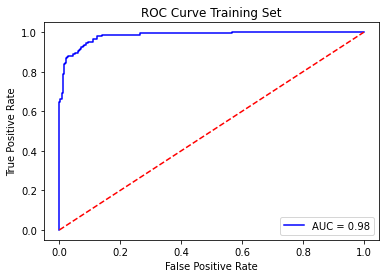

Confusion Matrix Test Set
[[72  0]
 [18 25]]


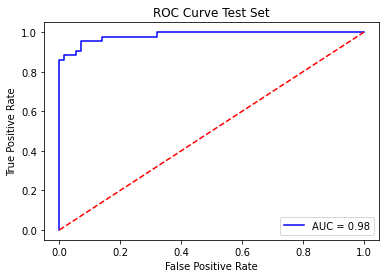

In [228]:
train_summary_df,test_summary_df = spectral(df_m,df_b)

In [229]:
train_summary_df.mean()

accuracy     0.855140
precision    0.983553
recall       0.621499
f1_score     0.760323
auc          0.979241
dtype: float64

In [230]:
test_summary_df.mean()

accuracy     0.853043
precision    0.991699
recall       0.612403
f1_score     0.753048
auc          0.981686
dtype: float64

In [231]:
average_scores["spectral"] ={
        "train":train_summary_df.mean(),
        "test":test_summary_df.mean()
}

In [249]:
for model in average_scores.keys():
    df = pd.DataFrame(columns=average_scores[model]['train'].keys())
    
    temp_arr1 = []
    temp_arr2 = []
    for col in average_scores[model]['train'].keys():
        temp_arr1.append(average_scores[model]['train'][col])
        temp_arr2.append(average_scores[model]['test'][col])
    df.loc[0] = temp_arr1
    df.loc[1] = temp_arr2
    print(model, "Summary")
    print(df)   
    print()

l1-svm Summary
   accuracy  precision    recall  f1_score       auc
0  0.987885   0.992578  0.974753  0.983555  0.998237
1  0.965797   0.969175  0.939535  0.953419  0.991354

semi-supervised Summary
   accuracy  precision    recall  f1_score       auc
0  0.992952   0.996714  0.983761  0.990167  0.998966
1  0.966377   0.979352  0.930233  0.953616  0.989341

unsupervised Summary
   accuracy  precision    recall  f1_score       auc
0  0.924890   0.950513  0.842406  0.893021  0.979948
1  0.929275   0.952895  0.853488  0.899639  0.980373

spectral Summary
   accuracy  precision    recall  f1_score       auc
0  0.855140   0.983553  0.621499  0.760323  0.979241
1  0.853043   0.991699  0.612403  0.753048  0.981686



From the summary, it is observed that supervised is better than semi-supervised learning. Semi-supervised is better than unsupervised learning. 

# 2. Active Learning Using Support Vector Machines

In [2]:
df = pd.read_csv("../data/data_banknote_authentication.txt",names=["variance","skewness","kurtosis","entropy","class"])
df

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [3]:
train, test = train_test_split(df, test_size=0.344)
train

,variance,skewness,kurtosis,entropy,class
385,2.37180,7.4908,0.015989,-1.74140,0
893,-0.77288,-7.4473,6.492000,0.36119,1
1009,-3.57130,-12.4922,14.888100,-0.47027,1
1137,-1.58770,-6.6072,5.802200,0.31593,1
733,3.82440,-3.1081,2.453700,0.52024,0
...,...,...,...,...,...
1223,1.34030,4.1323,-4.701800,-2.59870,1
206,5.30630,5.2684,-2.890400,-0.52716,0
9,1.53560,9.1772,-2.271800,-0.73535,0
1071,-2.53730,-6.9590,8.805400,1.52890,1


In [4]:
test

,variance,skewness,kurtosis,entropy,class
863,0.20216,1.91820,-3.282800,-0.617680,1
793,-2.28600,-5.44840,5.803900,0.882310,1
97,2.16160,-6.88040,8.151700,-0.081048,0
944,-2.12100,-0.05588,1.949000,1.353000,1
187,1.83140,6.36720,-0.036278,0.049554,0
...,...,...,...,...,...
877,-5.12160,-5.31180,10.384600,-1.061200,1
1228,-1.34140,-1.91620,-0.155380,-0.119840,1
1349,-1.58510,-2.15620,1.708200,0.901700,1
1272,-4.23330,4.91660,-0.492120,-5.320700,1


#### 2. (b) i. Passive Learning

In [5]:
def svm_passive(df):
    test_accs = []
    
    for m in range(50):
        train, test = train_test_split(df, test_size=0.344, random_state=(m+1)*10)
        xtest, ytest = test.iloc[:,:-1],test.iloc[:,-1]

        splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=(m+1)*10)
        C_list = [10**i for i in range(-3,7)]
        params = {"C":C_list}
        estimator = LinearSVC(penalty="l1", dual=False, verbose=0)

        train_inc = None
        test_acc = []
        while(len(train)>0):
            flag=1
            train_sub=None
            while(flag==1):
                train_sub = train.sample(n=10)
                if len(train_sub["class"].value_counts().index.to_list())==2:
                    if len(train)==900:
                        train_inc=train_sub
                    else:
                        train_inc=train_inc.append(train_sub,ignore_index=True)
                    train = train.loc[~train.index.isin(train_sub.index)]
                    flag=0

            xtrain, ytrain = train_inc.iloc[:,:-1],train_inc.iloc[:,-1]
            clf = GridSearchCV(estimator=estimator, param_grid=params, scoring="f1_weighted", n_jobs=-1, cv=splitter, verbose=0)
            clf.fit(xtrain,ytrain)

            ypred = clf.predict(xtest)
            test_acc.append(accuracy_score(ypred,ytest))
        print("Iteration ",m+1," Test accuracy with 900 samples:",test_acc[-1])
        test_accs.append(test_acc)
    
    test_accs = np.array(test_accs)
    mean_test_accs = np.mean(test_accs,axis=0)
    
    return mean_test_accs
    

In [6]:
passive_mean_accs = svm_passive(df)

Iteration  1  Test accuracy with 900 samples: 0.9936440677966102
Iteration  2  Test accuracy with 900 samples: 0.989406779661017
Iteration  3  Test accuracy with 900 samples: 0.9915254237288136
Iteration  4  Test accuracy with 900 samples: 0.989406779661017
Iteration  5  Test accuracy with 900 samples: 0.9915254237288136
Iteration  6  Test accuracy with 900 samples: 0.9936440677966102
Iteration  7  Test accuracy with 900 samples: 0.9936440677966102
Iteration  8  Test accuracy with 900 samples: 0.989406779661017
Iteration  9  Test accuracy with 900 samples: 0.989406779661017
Iteration  10  Test accuracy with 900 samples: 0.9915254237288136
Iteration  11  Test accuracy with 900 samples: 0.9915254237288136
Iteration  12  Test accuracy with 900 samples: 0.989406779661017
Iteration  13  Test accuracy with 900 samples: 0.9851694915254238
Iteration  14  Test accuracy with 900 samples: 0.989406779661017
Iteration  15  Test accuracy with 900 samples: 0.989406779661017
Iteration  16  Test accura

#### 2. (b) ii. Active Learning

In [7]:
def svm_active(df):
    test_accs = []
    
    for m in range(50):
        train, test = train_test_split(df, test_size=0.344, random_state=(m+1)*10)
        xtest, ytest = test.iloc[:,:-1],test.iloc[:,-1]
        

        splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=(m+1)*10)
        C_list = [10**i for i in range(-3,7)]
        params = {"C":C_list}
        estimator = LinearSVC(penalty="l1", dual=False, verbose=0)

        train_inc = None
        test_acc = []
        last_it = 0
        while(len(train)>=0):
            train_sub=None
            
            flag=1
            while(flag==1 and len(train)==900):
                train_sub = train.sample(n=10)
                if len(train_sub["class"].value_counts().index.to_list())==2:
                    train_inc=train_sub
                    train = train.loc[~train.index.isin(train_sub.index)]
                    flag=0
            
            xtrain, ytrain = train_inc.iloc[:,:-1],train_inc.iloc[:,-1]
            clf = GridSearchCV(estimator=estimator, param_grid=params, scoring="f1_weighted", n_jobs=-1, cv=splitter, verbose=0)
            clf.fit(xtrain,ytrain)
            
            if len(train)!=0:
                dist = clf.decision_function(train.iloc[:,:-1])
                train["dist"] = dist
                train["dist"] = train["dist"].abs()
                train.sort_values(by=['dist'],inplace=True)
                train.drop(columns=['dist'], inplace=True)
                train_inc = train_inc.append(train[:10],ignore_index=True)
                train = train[10:]
            
            ypred = clf.predict(xtest)
            test_acc.append(accuracy_score(ypred,ytest))
            
            if last_it == 1:
                break
            if(len(train)==0):
                last_it = 1
            
        print("Iteration ",m+1," Test accuracy with 900 samples:",test_acc[-1])
        
        test_accs.append(test_acc)
    
    test_accs = np.array(test_accs)
    mean_test_accs = np.mean(test_accs,axis=0)
    
    return mean_test_accs

In [8]:
active_mean_accs = svm_active(df)

Iteration  1  Test accuracy with 900 samples: 0.9936440677966102
Iteration  2  Test accuracy with 900 samples: 0.989406779661017
Iteration  3  Test accuracy with 900 samples: 0.9915254237288136
Iteration  4  Test accuracy with 900 samples: 0.989406779661017
Iteration  5  Test accuracy with 900 samples: 0.9915254237288136
Iteration  6  Test accuracy with 900 samples: 0.9936440677966102
Iteration  7  Test accuracy with 900 samples: 0.9936440677966102
Iteration  8  Test accuracy with 900 samples: 0.989406779661017
Iteration  9  Test accuracy with 900 samples: 0.989406779661017
Iteration  10  Test accuracy with 900 samples: 0.9915254237288136
Iteration  11  Test accuracy with 900 samples: 0.9915254237288136
Iteration  12  Test accuracy with 900 samples: 0.9915254237288136
Iteration  13  Test accuracy with 900 samples: 0.9851694915254238
Iteration  14  Test accuracy with 900 samples: 0.989406779661017
Iteration  15  Test accuracy with 900 samples: 0.9830508474576272
Iteration  16  Test accu

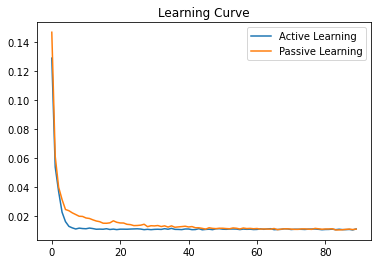

In [12]:
plt.plot([i for i in range(90)],1-active_mean_accs,label="Active Learning")
plt.plot([i for i in range(90)],1-passive_mean_accs,label="Passive Learning")
plt.title("Learning Curve")
plt.legend()